<a href="https://colab.research.google.com/github/dainilliniad/small311qlab/blob/neurowave/%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import os
import numpy as np
import torch #
import torchvision #
import matplotlib.pyplot as plt #
from time import time #
from torchvision import datasets, transforms #
from google.colab import drive #
from torch.utils.data import Dataset #
from torch.utils.data import DataLoader #
from tqdm import tqdm #
from torch.autograd import Variable #
import torch.nn as nn #
from torch import tensor
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
correlation1=np.load('/content/cor1.npy') #тут указать свой путь до
correlation2=np.load('/content/cor2.npy')
correlation3=np.load('/content/cor3.npy')
pitog=np.load('/content/pitog.npy')
tetta=np.load('/content/tetitog.npy')   #файлов numpy, созданных в первой части проекта

In [51]:
class LAADataset(Dataset): #создание датасетов из наших файлов
    def __init__(self, Corr_data_g1, Corr_data_g2, Corr_data_g3, Theta_data, P_data, x_0, x_end):
      self.LAAdata = []
      self.len_data = x_end-x_0
      for obj in tqdm(range(self.len_data)):
        self.LAAdata.append((tensor([Corr_data_g1[obj],Corr_data_g2[obj],Corr_data_g3[obj]]),tensor([(Theta_data[obj]),P_data[obj]])))

    def __len__(self):
      return self.len_data

    def __getitem__(self, idx):
      return self.LAAdata[idx][0],self.LAAdata[idx][1]

In [52]:
#объявление модели, число нейронов в слоях
model = torch.nn.Sequential(
        torch.nn.Linear(3, 50, bias=False),
        nn.BatchNorm1d(50),
        torch.nn.ReLU(),

        torch.nn.Linear(50, 200, bias=False),
        nn.BatchNorm1d(200),
        torch.nn.ReLU(),

        torch.nn.Linear(200, 600, bias=False),
        nn.BatchNorm1d(600),
        torch.nn.ReLU(),

        torch.nn.Linear(600, 200, bias=False),
        nn.BatchNorm1d(200),
        torch.nn.ReLU(),

        torch.nn.Linear(200, 100, bias=False),
        nn.BatchNorm1d(100),
        torch.nn.ReLU(),

        torch.nn.Linear(100, 25, bias=False),
        nn.BatchNorm1d(25),
        torch.nn.ReLU(),

        torch.nn.Linear(25, 2)
        )

In [66]:
# Длина обучающей и тестирующей выборок
lenTestData = 1000 #длина тестовой выборки
lenTrainData = 14500 #длина обучающей выборки
batch_size = 200 #размер батча
epoches=15 #число эпох
criterion = torch.nn.MSELoss() #критерий оптимизации ошибки - среднеквадратический
optimizer = torch.optim.Adam(model.parameters(), lr=(1e-5)*2)  #шаг спуска - 10^-4

testDatasets = LAADataset(correlation1,correlation2, correlation3, tetta, pitog, 0,lenTestData)
trainDatasets = LAADataset(correlation1,correlation2, correlation3, tetta, pitog,lenTestData,lenTrainData+lenTestData)

testDataloader = DataLoader(testDatasets, batch_size=batch_size, shuffle=False, num_workers=2)
trainDataloader = DataLoader(trainDatasets, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 14500/14500 [00:00<00:00, 67346.82it/s]


In [67]:
#обучение модели по эпохам
model = model.float()
loss_train = []
loss_test = []
loss_train_tet = []
loss_test_tet = []
loss_train_p = []
loss_test_p = []

for epoch in range(epoches):
  model.train()
  for corf, tettab in trainDataloader:

    tettab = tettab.float()
    output = model(corf.float()) #получаем результат
    loss = criterion(output, tettab)  #считаем ошибку по критерию
    loss_tetta=criterion(output[0], tettab[0]) #считаем ошибку тетта по критерию
    loss_p=criterion(output[1], tettab[1]) #считаем ошибку p по критерию

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_train.append(loss.item())
  loss_train_tet.append(loss_tetta.item())
  loss_train_p.append(loss_p.item())

  model.eval()
  for corf, tettab in testDataloader:  #тоже самое, только для тестовой выборки
    tettab = tettab.float()
    output = model(corf.float())
    loss = criterion(output, tettab)
    loss_tetta=criterion(output[0], tettab[0])
    loss_p=criterion(output[1], tettab[1])

  loss_test.append(loss.item())
  loss_test_tet.append(loss_tetta.item())
  loss_test_p.append(loss_p.item())
  print('Epoch: ', epoch, 'Loss: ', loss.item())

Epoch:  0 Loss:  0.01777663640677929
Epoch:  1 Loss:  0.017050080001354218
Epoch:  2 Loss:  0.01720523275434971
Epoch:  3 Loss:  0.016962643712759018
Epoch:  4 Loss:  0.016690418124198914
Epoch:  5 Loss:  0.01681983470916748
Epoch:  6 Loss:  0.016918107867240906
Epoch:  7 Loss:  0.017935821786522865
Epoch:  8 Loss:  0.01749519817531109
Epoch:  9 Loss:  0.017505114898085594
Epoch:  10 Loss:  0.016648268327116966
Epoch:  11 Loss:  0.017103053629398346
Epoch:  12 Loss:  0.01852583698928356
Epoch:  13 Loss:  0.018747936934232712
Epoch:  14 Loss:  0.016649845987558365


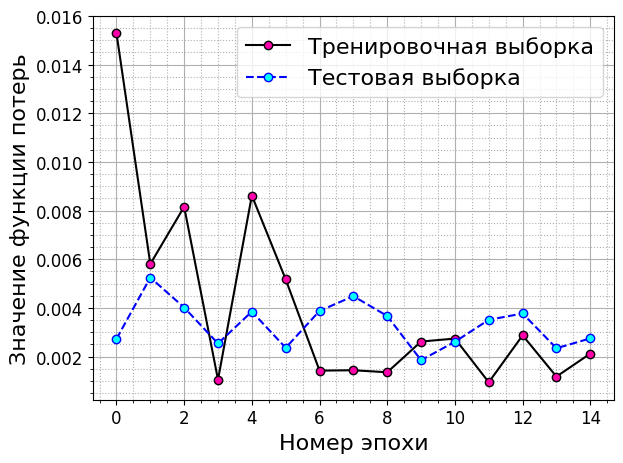

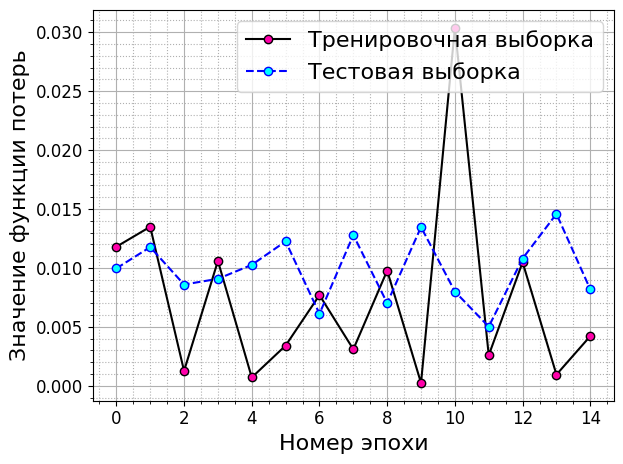

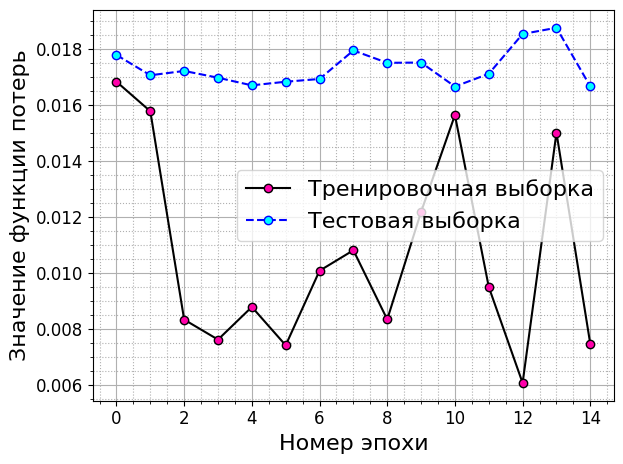

In [68]:
def plotLoss(localtest, localtrain, name):
  fig, ax = plt.subplots()
  matplotlib.rcParams.update({'font.size': 12})
  ax.plot(localtrain, linestyle='-', marker='o', color='k',
         markerfacecolor='#ff00aaff', label='Тренировочная выборка')
  ax.plot(localtest, linestyle='--', marker='o', color='b',
         markerfacecolor='#00ffffff',  label='Тестовая выборка')
  ax.legend(fontsize=16)
  ax.minorticks_on()
  ax.set_xlabel('Номер эпохи', fontsize=16)
  ax.set_ylabel(r'Значение функции потерь', fontsize=16)
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  plt.tight_layout()
  fig.savefig(name + ".png",dpi = 300)
  fig.show()

plotLoss(loss_test_p,loss_train_p,'loss')
plotLoss(loss_test_tet,loss_train_tet,'loss')
plotLoss(loss_test,loss_train,'loss')

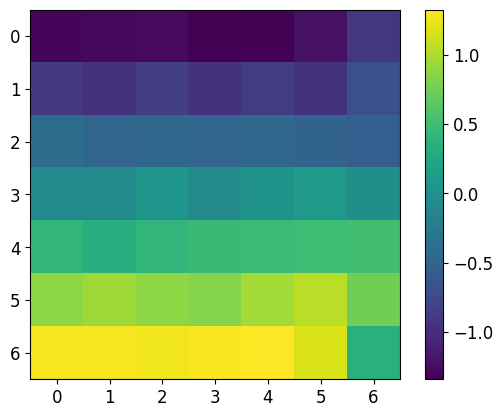

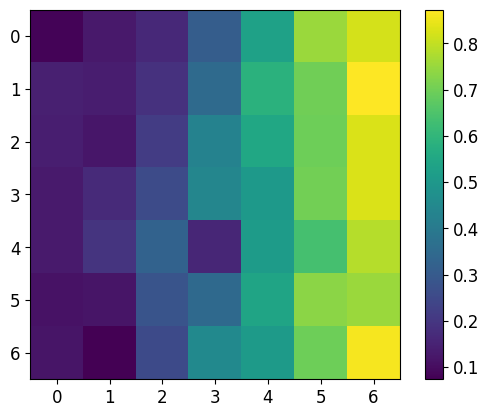

In [69]:
length=7  #длина изображение, примем 7, длина равна ширине
width=length   #ширина изображение, примем квадратным, длина равна ширине
x=[[-0.0011,  0.0105,  0.0182,  0.0314,  0.0679,  0.1340,  0.1829],
        [ 0.1035,  0.0631,  0.1186,  0.1085,  0.1593,  0.1842,  0.2192],
        [ 0.2189,  0.2091,  0.2021,  0.2051,  0.2404,  0.2139,  0.2418],
        [ 0.2402,  0.2645,  0.2518,  0.2472,  0.2493,  0.2485,  0.2433],
        [ 0.2103,  0.2189,  0.2066,  0.2002,  0.2069,  0.2107,  0.2279],
        [ 0.0971,  0.0777,  0.1157,  0.1300,  0.1336,  0.1571,  0.1958],
        [ 0.0207,  0.0098,  0.0439,  0.0796,  0.0865,  0.1385,  0.1784]]
y=[[0.0751, 0.0667, 0.0718, 0.1056, 0.1372, 0.1692, 0.2056],
        [0.0028, 0.0326, 0.0063, 0.0393, 0.0857, 0.1088, 0.1840],
        [0.0325, 0.0191, 0.0414, 0.0720, 0.0854, 0.1327, 0.1694],
        [0.1114, 0.1111, 0.1446, 0.1364, 0.1635, 0.2001, 0.2136],
        [0.2293, 0.2042, 0.2064, 0.2232, 0.2235, 0.2344, 0.2516],
        [0.2617, 0.2586, 0.2506, 0.2572, 0.2385, 0.2454, 0.2707],
        [0.1796, 0.1865, 0.1984, 0.1818, 0.1873, 0.2147, 0.2173]]
z=[[ 0.2341,  0.2399,  0.2241,  0.2507,  0.2423,  0.2285,  0.2516],
        [ 0.1644,  0.1570,  0.1611,  0.1815,  0.1916,  0.2215,  0.2083],
        [ 0.0447,  0.0633,  0.0674,  0.0891,  0.1201,  0.1479,  0.2040],
        [-0.0008,  0.0082,  0.0252,  0.0549,  0.0720,  0.1232,  0.1828],
        [ 0.0362,  0.0390,  0.0709,  0.0527,  0.1059,  0.1397,  0.1784],
        [ 0.1436,  0.1580,  0.1586,  0.1554,  0.1948,  0.2244,  0.2007],
        [ 0.2328,  0.2510,  0.2370,  0.2411,  0.2573,  0.2395,  0.2567]]
#x, y, z - 3 корреляционные функции g1, g2, g3 которые тестируем на сетке
t=[]
for i in range(length):
  for j in range(width):
    t.append([x[i][j], y[i][j], z[i][j]])

model1=model(torch.tensor(t))
p=[]
tet=[]
p1=[]
tet1=[]
for i in range(length*width):
  if len(p1)!=length:
     p1.append(float(model1[i][1]))
     tet1.append(float(model1[i][0]))
  else:
    p.append(p1)
    tet.append(tet1)
    p1=[]
    tet1=[]
    p1.append(float(model1[i][1]))
    tet1.append(float(model1[i][0]))
p.append(p1)
tet.append(tet1)

p=torch.tensor(p)  #переводим в тензоры
tet=torch.tensor(tet)  #переводим в тензоры

plt.imshow(tet)
plt.colorbar()
plt.show()
plt.imshow(p)
plt.colorbar()
plt.show()